# Get 4 pots

For the preliminary data, each raw scan consisted of 4 different pots arranged in a square.

- Since the 4 pots touch each other, we cannot simply look for 4 separate components.
- We thus look to compute the bounding rectangle.
- We then split this rectangle into four equal rectangles, one per pot.
- Doing some basic linear algebra, we can define the vectors that determine each line, and with dot products we can determine sides.

In [1]:
import tifffile as tf
import numpy as np
import pandas as pd
import numpy.polynomial.polynomial as P
import scipy.spatial as spatial
import scipy.ndimage as ndimage
from importlib import reload

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

## Load the airless, soilless scan

In [2]:
tiff_file = '../raw3d/u112-3.tif'
pot_dst = '../pots/'

src, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

dst = pot_dst + bname + '/'

In [3]:
filename = dst + 'soilless.tif'
img = tf.imread(filename)

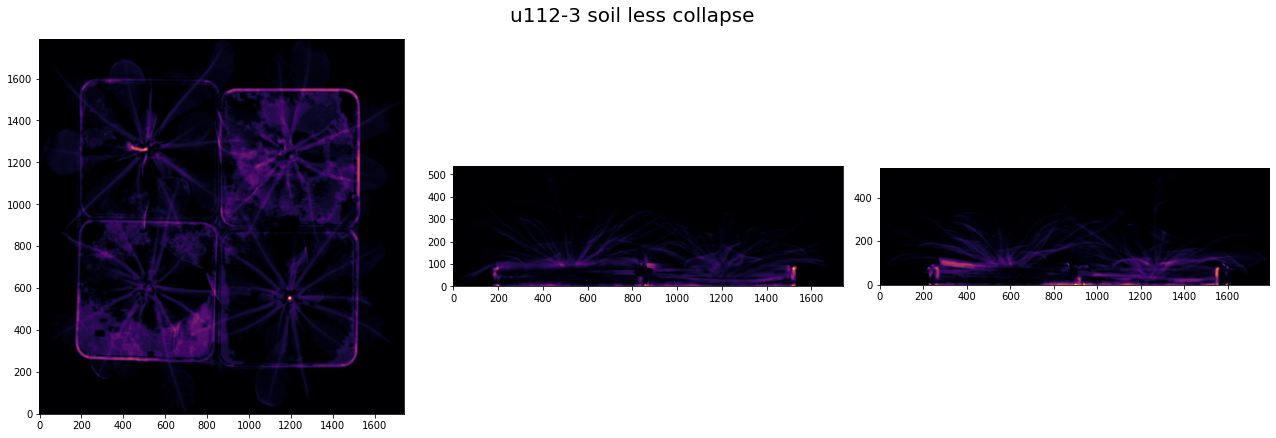

In [4]:
snaps = thales.collapse_dimensions(img)
thales.plot_collapse_dimensions(snaps, bname, 'soil less')

## Bring everything down to 2D

Our main goal is to figure out the contour of the pots.

- We project all voxels on the $z=0$ plane. 
- Threshold out the low intensity voxels to remove remaining noise or protruding leaves: focus just on the pot
- Binarize the 2D image.
- Get its contour by convolving the image with the matrix
$$\begin{bmatrix}
-1 & -1 & -1 \\
-1 & 8  & -1 \\
-1 & -1 & -1
\end{bmatrix}$$
- A voxel will end with a positive value iff the voxel is on the contour.

In [8]:
pts = snaps[0].copy()
pts = (255*pts/np.max(pts)).astype(np.uint8).reshape(snaps[0].shape)
pts[pts < 70] = 0
pts[pts > 0] = 1
border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

## Compute the bounding rectangle

- This computation was done with this [piece of code](https://bitbucket.org/william_rusnack/minimumboundingbox/src/master/MinimumBoundingBox.py) by William Rusnack.

- Then it is easy to order the corners as
    - leftmost &rarr; topmost &rarr; rightmost &rarr; bottommost

In [9]:
corners = thales.four_corners(surface)
tpt, rpt, bpt, lpt = corners
center = np.mean(corners,axis=0)
print(tpt, rpt, bpt, lpt, sep='\n')

rhull = np.vstack((lpt,tpt,rpt,bpt,lpt))

[1602.36537848  199.88589854]
[1576.77241481 1542.23684299]
[ 219.86432153 1516.36633597]
[245.4572852  174.01539152]


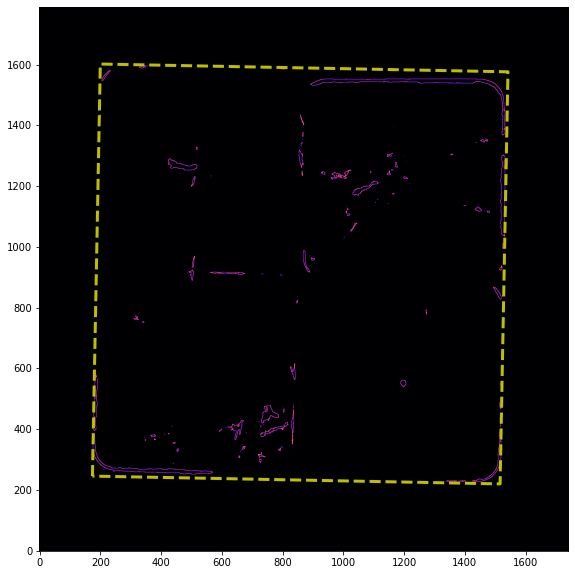

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
#plt.plot(rect[hull.vertices,1], rect[hull.vertices,0], 'y--', lw=2);
plt.plot(rhull[:,1], rhull[:,0], 'y--', lw=3);

In [11]:
pts = snaps[0].copy()
pts = (255*pts/np.max(pts)).astype(np.uint8).reshape(snaps[0].shape)
pts[pts > 0] = 1
surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

## Define the rectangle lines and splitting middle lines

- Given two points we can easily compute the line coefficients $\ell: y = ax + b$ for the four border lines (yellow below).

- We can compute the midpoints between each pair of corners to define the midpoints of the rectangle sides (green octagon).

- Compute the coeficients of the two perpendicular bisectors of the rectangle sides (green lines)

- Similarly compute the center point (magenta diamondo)

- Also the center of each pot (cyan x).

In [12]:
bcoefs = thales.four_borderlines(corners)
midpoints = thales.four_midpoints(corners)
mcoefs = thales.midline_splits(midpoints)
centers = thales.four_centers(corners, midpoints)

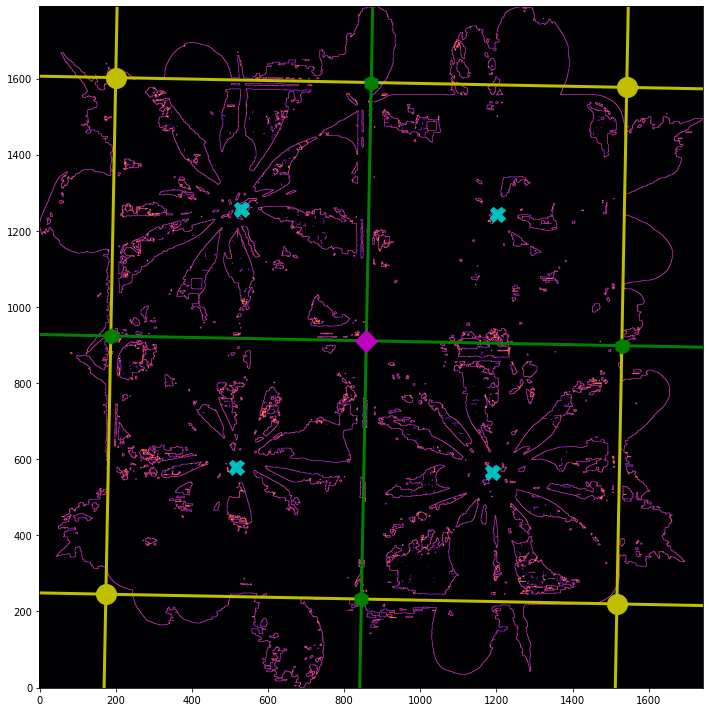

In [13]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
for i in range(len(bcoefs)):
    plt.axline(corners[i,:][::-1], slope=bcoefs[i,1], c='y', lw=3)
    plt.plot(corners[i,1], corners[i,0], 'yo', ms=20)
    plt.plot(centers[i,1], centers[i,0], 'cX', ms=15)
    plt.plot(midpoints[i,1], midpoints[i,0], 'gh', ms=15)
for i in range(len(mcoefs)):
    plt.axline(midpoints[i,:][::-1], slope=mcoefs[i,1], c='g', lw=3)

plt.plot(center[1], center[0], 'mD', ms=15);
plt.tight_layout()

filename = dst + bname + '_split_pots.jpg'
plt.savefig(filename, dpi=96, pil_kwargs={'optimize':True})

## Inner products to determine location

Lines are hyperplanes in 2D.

Recall that a hyperplane $H$ can be defined as $H = \{\vec z: \langle \vec w, \vec z\rangle + b = 0\}$, with $\vec w$ the normal unit vector and a scalar $b$.

Some pre-calculus reveals that $b$ is actually the minimum distance from the origin to the hyperplane.

The sign of $\langle \vec w, \vec z\rangle + b$ determines whether point $\vec z$ is to the left or the right of the hyperplane $H$ (_right_ and _left_ depend on the sign of $\vec w$). If it is zero, then $\vec z$ is actually standing right on $H$.

We are thus able to determine the voxels corresponding to each quadrant.

In [15]:
foo = midpoints - center
bar = np.sqrt(np.sum(foo**2, axis=1)).reshape(foo.shape[0],1)
WS = foo/bar
bs = bcoefs[:,0]/(bcoefs[:,1]*WS[:,1] - WS[:,0])

In [16]:
foo = midpoints[np.array([2,1]), :] - corners[2,:]
bar = np.sqrt(np.sum(foo**2, axis=1)).reshape(foo.shape[0],1)
ZS = foo/bar
cs = mcoefs[:,0]/(mcoefs[:,1]*ZS[:,1] - ZS[:,0])

### Save the coefficients and vectors

In [17]:
filename = dst + bname + '_2d_measurements.csv'

columns = ['cornerX', 'cornerY',
           'border_int', 'border_slope',
           'midpointX', 'midpointY',
           'centersX', 'centersY',
           'WX', 'WY', 'b']

index = ['tmost', 'rmost', 'bmost', 'lmost']

pd.DataFrame(np.column_stack((corners, bcoefs, midpoints, centers, WS, bs)), 
             columns=columns, index=index).to_csv(filename)

In [18]:
filename = dst + bname + '_2d_measurements_supp.csv'

columns = ['mid_int', 'mid_slope', 'ZX', 'ZY', 'c']

index = ['horz', 'vert']

pd.DataFrame(np.column_stack((mcoefs, ZS, cs)),
             columns=columns, index=index).to_csv(filename)

# Go to 3D

- Get the Cartesian coordinates of the scan.

In [19]:
coords = thales.tiff2coords(img, False)
print(coords.shape) #84.9M

(31369680, 3)


In [20]:
W3D = np.column_stack((np.zeros(len(WS)), WS))
Z3D = np.column_stack((np.zeros(len(ZS)), ZS))

Ignore all the voxels outside the yellow bounding box

**We might want to avoid this step, since it removes parts of leaves protruding out of the pot**

In [45]:
orientation = np.full((len(coords), len(W3D)), False, dtype=np.bool)

for i in range(len(W3D)):
    W = W3D[i, :]
    b = bs[i]

    orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

coords = coords[np.sum(orientation, axis=1) == len(W3D),:]

Follow the orientation with respect to each line bisector (green lines).

In [21]:
orientation = np.full((len(coords), len(Z3D)), False, dtype=np.bool)

for i in range(len(Z3D)):
    W = Z3D[i, :]
    b = cs[i]

    orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

In [22]:
potcoords = coords[np.sum(orientation, axis=1) == len(Z3D), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[tuple(potcoords.T)] = True

pot3 = new_mask*img
snaps3 = thales.collapse_dimensions(pot3)

(5556942, 3)


In [23]:
potcoords = coords[np.sum(orientation, axis=1) == 0, :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[tuple(potcoords.T)] = True

pot0 = new_mask*img
snaps0 = thales.collapse_dimensions(pot0)

(5259969, 3)


In [24]:
orientation = np.full((len(coords), len(Z3D)), False, dtype=np.bool)

i=0
W = Z3D[i, :]
b = cs[i]
orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

i=1
W = Z3D[i, :]
b = cs[i]
orientation[:, i] = np.sum(coords*W, axis=1) + b < 0

In [25]:
potcoords = coords[(np.sum(orientation, axis=1) == 1) & (orientation[:,1]), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[tuple(potcoords.T)] = True

pot2 = new_mask*img
snaps2 = thales.collapse_dimensions(pot2)

(9651610, 3)


In [26]:
potcoords = coords[(np.sum(orientation, axis=1) == 1) & (orientation[:,0]), :]
print(potcoords.shape)

new_mask = np.empty_like(img)
new_mask[tuple(potcoords.T)] = True

pot1 = new_mask*img
snaps1 = thales.collapse_dimensions(pot1)

(10901159, 3)


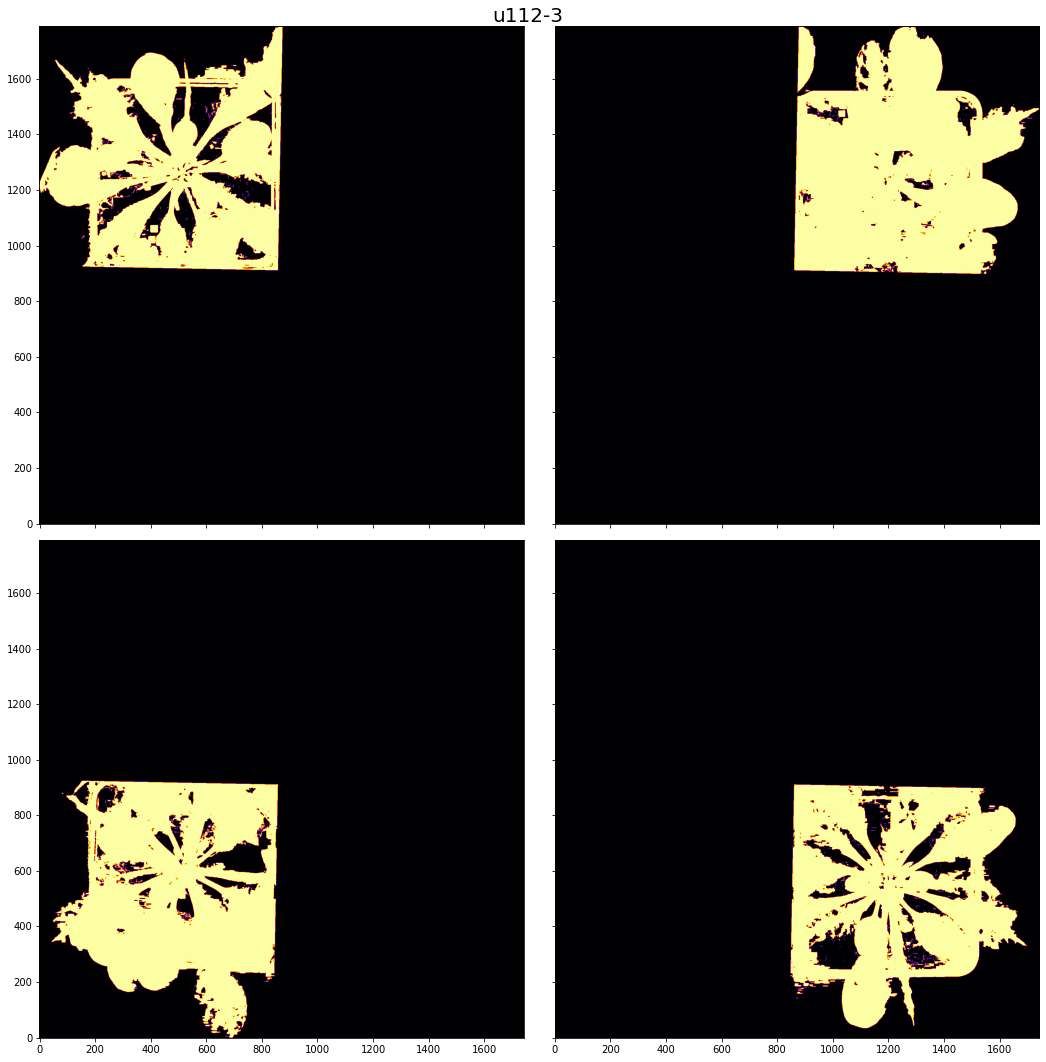

In [27]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(snaps0[0] > 0, cmap='inferno', origin='lower');
ax[0,1].imshow(snaps1[0] > 0, cmap='inferno', origin='lower');
ax[1,0].imshow(snaps2[0] > 0, cmap='inferno', origin='lower');
ax[1,1].imshow(snaps3[0] > 0, cmap='inferno', origin='lower');

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'_separated_pots_4_binary.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

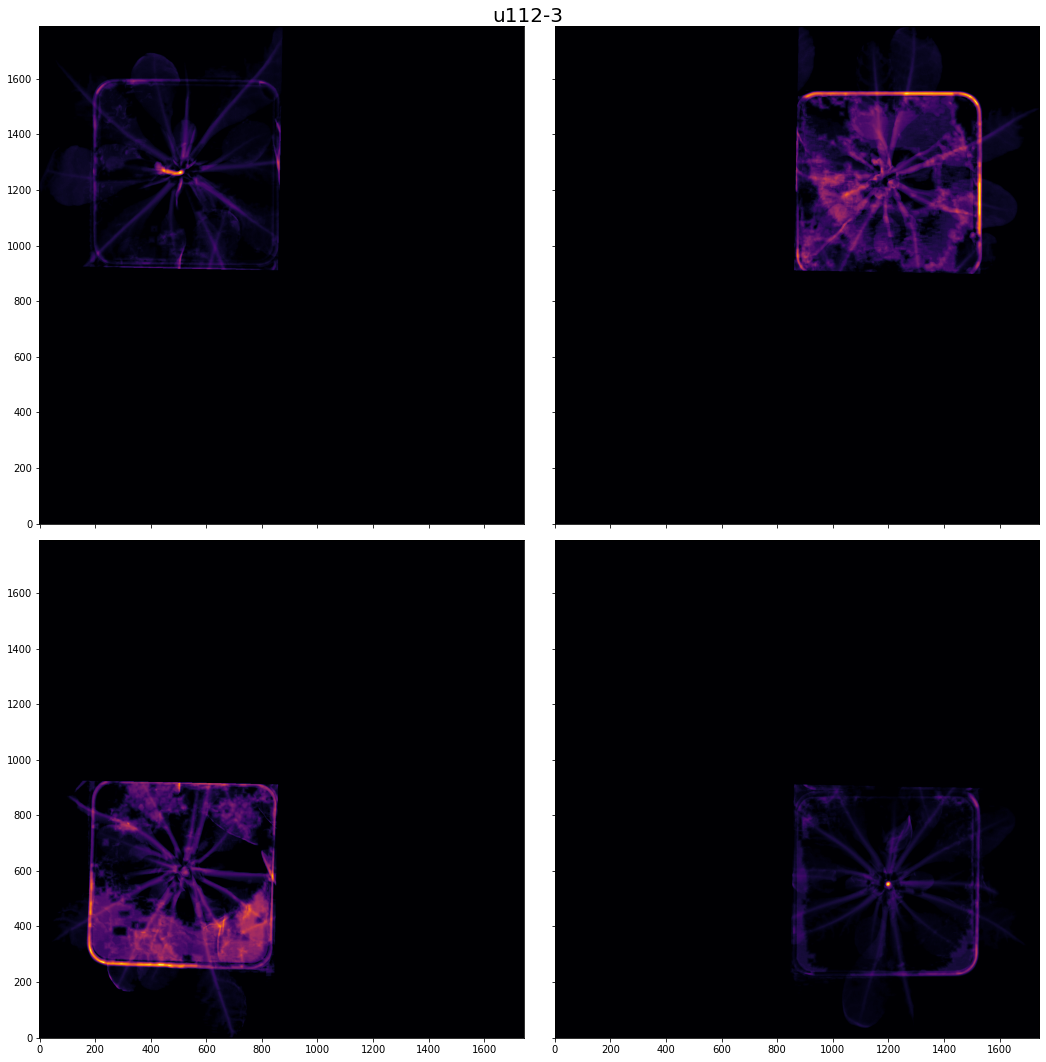

In [28]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(snaps0[0], cmap='inferno', origin='lower');
ax[0,1].imshow(snaps1[0], cmap='inferno', origin='lower');
ax[1,0].imshow(snaps2[0], cmap='inferno', origin='lower');
ax[1,1].imshow(snaps3[0], cmap='inferno', origin='lower');

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'_separated_pots_4_color.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

In [29]:
filename = dst + bname + '_pot'

tf.imwrite(filename + '0.tif', pot0 , photometric='minisblack',compress=3)
tf.imwrite(filename + '1.tif', pot1 , photometric='minisblack',compress=3)
tf.imwrite(filename + '2.tif', pot2 , photometric='minisblack',compress=3)
tf.imwrite(filename + '3.tif', pot3 , photometric='minisblack',compress=3)